<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE40455](https://jckantor.github.io/CBE40455) by
Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE40455.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [Jesuit Volunteer Corps](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/04.04-Jesuit-Volunteer-Corps.ipynb) | [Contents](toc.ipynb) | [Scheduling Multipurpose Batch Processes using State-Task Networks](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/04.06-Scheduling-Multipurpose-Batch-Processes-using-State-Task-Networks.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/04.05-Unit-Commitment.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/04.05-Unit-Commitment.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Unit Commitment

The production of electrical power to meet the demands of a regional power grid is among the most complex and important applications of mathematical optimization. A full treatment of the problem would consider the dispatch of mulitiple generating units and storage systems and the allocation of transportation resources to meet the projected demands of users.

The scope of this notebook is an elementary introduction to the models used for unit commitment and closely follows [Unit Commitment](https://yalmip.github.io/example/unitcommitment/).  A more comprehensive discussion and implemenation can be found in the open source [Dispa-Set](http://www.dispaset.eu/en/latest/) package.

## Install Pyomo and Solvers for Google Colaboratory

### Install and Import Pyomo

In [0]:
!pip install -q pyomo
import pyomo.environ as pyo

### Install COIN-OR BONMIN and Create Solver

In [0]:
!wget -N -q "https://ampl.com/dl/open/bonmin/bonmin-linux64.zip"
!unzip -o -q bonmin-linux64
bonmin = pyo.SolverFactory('bonmin', executable='/content/bonmin')

## Unit Specifications

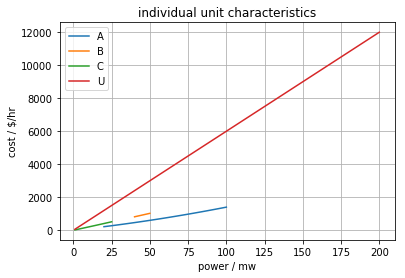

In [0]:
import numpy as np
import matplotlib.pyplot as plt

units = {
    'A': {'Pmin': 20, 'Pmax': 100, 'Q': 0.04, 'C': 10, 'min_up':  6, 'min_down': 3},
    'B': {'Pmin': 40, 'Pmax':  50, 'Q': 0.01, 'C': 20, 'min_up': 30, 'min_down': 6},
    'C': {'Pmin':  1, 'Pmax':  25, 'Q': 0.02, 'C': 20, 'min_up':  1, 'min_down': 3},
    'U': {'Pmin':  1, 'Pmax': 200, 'Q': 0.00, 'C': 60, 'min_up':  0, 'min_down': 0}
}

for key,unit in units.items():
    P = np.linspace(unit['Pmin'], unit['Pmax'])
    C = unit['Q']*P**2 + unit['C']*P
    plt.plot(P, C, label=key)

plt.title('individual unit characteristics')
plt.xlabel('power / mw')
plt.ylabel('cost / $/hr')
plt.legend()
plt.grid(True)

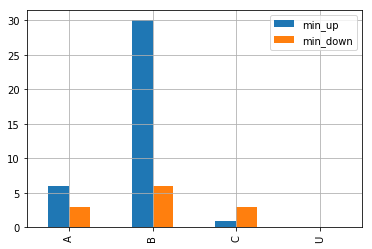

In [0]:
import pandas as pd

df = pd.DataFrame(units).T
df[['min_up','min_down']].plot(kind='bar', grid=True)

## Unit Commitment Model 1.  Constant Demand without Uptime or Downtime Constraints

The model is created with a mutable parameter so that the model can be solved for multiple parameters without having to reconstruct the model from scratch for every value.

In [0]:
def unit_commitment(units, Pforecast):
    m = pyo.ConcreteModel()
    
    m.units = pyo.Set(initialize = units.keys())
    m.P = pyo.Var(m.units, domain=pyo.NonNegativeReals)
    m.x = pyo.Var(m.units, domain=pyo.Binary)

    m.cost = pyo.Objective(expr=sum(units[k]['Q']*m.P[k]**2 + units[k]['C']*m.P[k] for k in m.units), sense=pyo.minimize)

    m.a = pyo.Constraint(m.units, rule=lambda m, k: m.x[k]*units[k]['Pmin'] <= m.P[k])
    m.b = pyo.Constraint(m.units, rule=lambda m, k: m.x[k]*units[k]['Pmax'] >= m.P[k])
    m.c = pyo.Constraint(expr=sum([m.P[k] for k in m.units]) >= Pforecast)
    
    results = bonmin.solve(m)
    return m
  
c = []
P = []

Pforecast = np.linspace(0, 175, 176)
for p in Pforecast:
  m = unit_commitment(units, p)
  c.append(m.cost())
  P.append([m.P[k]() for k in units.keys()])

### Cost

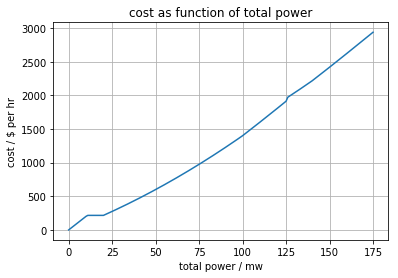

In [0]:
plt.plot(Pforecast, c)
plt.title('cost as function of total power')
plt.xlabel('total power / mw')
plt.ylabel('cost / $ per hr')
plt.grid(True)

### Unit Commitment Strategy

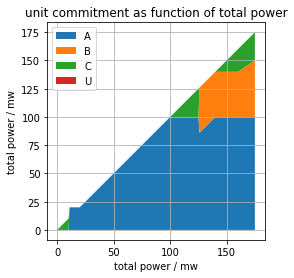

In [0]:
fig, ax = plt.subplots(1,1)
P = np.array(P)
base = 0
for k in range(len(P[0,:])):
    ax.fill_between(Pforecast, base, base + P[:,k])
    base += P[:,k]
ax.set_title('unit commitment as function of total power')
ax.set_xlabel('total power / mw')
ax.set_ylabel('total power / mw')
ax.legend(units.keys(), loc='upper left')
ax.axis('equal')
ax.axis('square')
ax.grid(True)

## Unit Commitment Model 2. Variable Demand without Uptime or Downtime Constraints

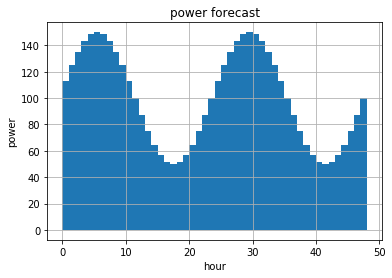

In [0]:
horizon = 48
t = np.linspace(1, horizon, horizon)
Pforecast = {t:100.0 + 50*np.sin(t*2*np.pi/24) for t in t}

def poststep(x, y):
  xstep = np.array([x[0]-(x[1]-x[0]), x[0]])
  ystep = np.array([y[0], y[0]])
  for k in range(1, len(x)):
      xstep = np.append(xstep, [x[k-1], x[k]])
      ystep = np.append(ystep, [y[k], y[k]])
  return xstep, ystep

fig, ax = plt.subplots(1,1)
ts, ps = poststep(t, np.array([Pforecast[t] for t in t]))
ax.fill_between(ts, 0, ps)
ax.set_title('power forecast')
ax.set_xlabel('hour')
ax.set_ylabel('power')
ax.grid(True)

In [0]:
def unit_commitment(units, horizon, Pforecast):
    m = pyo.ConcreteModel()
    m.t = pyo.RangeSet(1, horizon)
    
    m.units = pyo.Set(initialize = units.keys())
    m.P = pyo.Var(m.units, m.t, domain=pyo.NonNegativeReals)
    m.x = pyo.Var(m.units, m.t, domain=pyo.Binary)

    m.cost = pyo.Objective(expr=sum(units[k]['Q']*m.P[k,t]**2 + units[k]['C']*m.P[k,t] for k in m.units for t in m.t), sense=pyo.minimize)

    m.a = pyo.Constraint(m.units, m.t, rule=lambda m, k, t: m.x[k,t]*units[k]['Pmin'] <= m.P[k,t])
    m.b = pyo.Constraint(m.units, m.t, rule=lambda m, k, t: m.x[k,t]*units[k]['Pmax'] >= m.P[k,t])
    m.c = pyo.Constraint(m.t, rule=lambda m, t: sum([m.P[k,t] for k in m.units]) >= Pforecast[t])
    
    results = bonmin.solve(m)
    return m

m = unit_commitment(units, horizon, Pforecast)

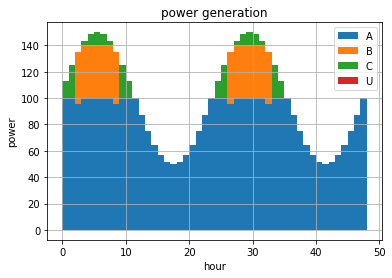

In [0]:
t = np.array([t for t in m.t])
P = {k:np.array([m.P[k,t]() for t in m.t]) for k in units.keys()}

base = 0
fig, ax = plt.subplots(1,1)
for k in P.keys():
  ts, ps = poststep(t, P[k])
  ax.fill_between(ts, base, base + ps, label=k)
  base += ps
ax.legend()
ax.set_title('power generation')
ax.set_xlabel('hour')
ax.set_ylabel('power')
ax.grid(True)

## Unit Commitment Model 3. Variable Demand with Uptime and Downtime Constraints

In [0]:
def unit_commitment(units, horizon, Pforecast):
    m = pyo.ConcreteModel()
    m.t = pyo.RangeSet(1, horizon)
    
    m.units = pyo.Set(initialize = units.keys())
    m.P = pyo.Var(m.units, m.t, domain=pyo.NonNegativeReals)
    m.x = pyo.Var(m.units, m.t, domain=pyo.Binary)
    m.y = pyo.Var(m.units, m.t, domain=pyo.Binary)
    m.z = pyo.Var(m.units, m.t, domain=pyo.Binary)

    m.cost = pyo.Objective(expr=sum(units[k]['Q']*m.P[k,t]**2 + units[k]['C']*m.P[k,t] for k in m.units for t in m.t), sense=pyo.minimize)

    m.a = pyo.Constraint(m.units, m.t, rule=lambda m, k, t: m.x[k,t]*units[k]['Pmin'] <= m.P[k,t])
    m.b = pyo.Constraint(m.units, m.t, rule=lambda m, k, t: m.x[k,t]*units[k]['Pmax'] >= m.P[k,t])
    m.c = pyo.Constraint(m.t, rule=lambda m, t: sum([m.P[k,t] for k in m.units]) >= Pforecast[t])
    
    def _d(m, k, t):
        if t <= 1:
            return pyo.Constraint.Skip
        else:
            return m.x[k,t] == m.x[k,t-1] + m.y[k,t] - m.z[k,t]
    m.d = pyo.Constraint(m.units, m.t, rule=_d)
    
    def _e(m, k, t):
        if units[k]['min_up'] == 0:
            return pyo.Constraint.Skip
        else:
            return units[k]['min_up']*m.y[k,t] <= sum(m.x[k,s] for s in range(t, min(t+units[k]['min_up'], horizon)))
    m.e = pyo.Constraint(m.units, m.t, rule=_e)
    
    def _f(m, k, t):
        if units[k]['min_down'] == 0:
            return pyo.Constraint.Skip
        else:
            return units[k]['min_down']*(1-m.z[k,t]) >= sum(m.x[k,s] for s in range(t, min(t+units[k]['min_down'], horizon)))
    m.f = pyo.Constraint(m.units, m.t, rule=_f)
    
    results = bonmin.solve(m)
    return m

m = unit_commitment(units, horizon, Pforecast)

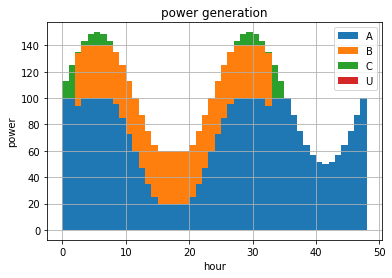

In [0]:
t = np.array([t for t in m.t])
P = {k:np.array([m.P[k,t]() for t in m.t]) for k in units.keys()}

base = 0
fig, ax = plt.subplots(1,1)
for k in P.keys():
    ts, ps = poststep(t, P[k])
    ax.fill_between(ts, base, base + ps, label=k)
    base += ps
ax.legend()
ax.set_title('power generation')
ax.set_xlabel('hour')
ax.set_ylabel('power')
ax.grid(True)

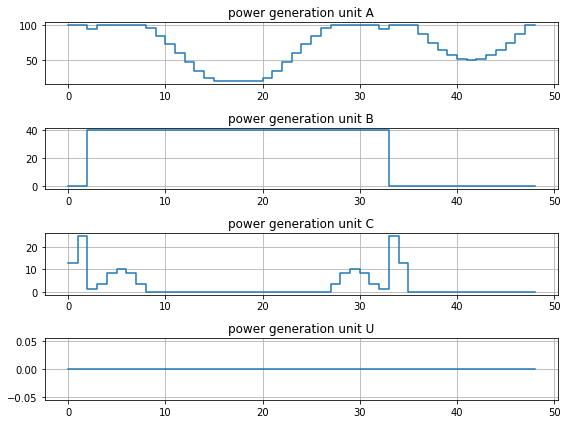

In [0]:
fig, ax = plt.subplots(len(P), 1, figsize=(8, 1.5*len(P)))
keys = [k for k in P.keys()]

for k in range(0, len(P)):
    ts, ps = poststep(t, P[keys[k]])
    ax[k].plot(ts, ps)
    ax[k].set_title('power generation unit ' + str(keys[k]))
    ax[k].grid()
    
plt.tight_layout()

<!--NAVIGATION-->
< [Jesuit Volunteer Corps](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/04.04-Jesuit-Volunteer-Corps.ipynb) | [Contents](toc.ipynb) | [Scheduling Multipurpose Batch Processes using State-Task Networks](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/04.06-Scheduling-Multipurpose-Batch-Processes-using-State-Task-Networks.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/04.05-Unit-Commitment.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/04.05-Unit-Commitment.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>